# 프로야구 선수의 다음 해 연봉 예측하기
- 회귀 분석 : 독립변수(X)와 종속변수(Y) 간의 관계를 찾아내는 것
- 방정식의 계수 w와 b를 잘 정하는 것
## step 1 탐색 : 프로 야구 연봉 데이터 살펴보기

In [2]:
# 프로야구 연봉 데이터셋의 기본 정보 구하기
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

picher_file_path = '../data/picher_stats_2017.csv'
batter_file_path = '../data/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [3]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [4]:
print(picher.shape)

(152, 22)


In [5]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

In [8]:
# 한글 폰트 적용
import matplotlib as mpl
mpl.rc("font", family="NanumGothic")

<AxesSubplot:>

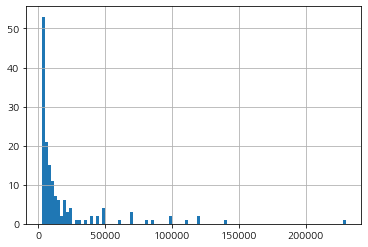

In [10]:
# 2018년 연봉 분포를 출력
picher['연봉(2018)'].hist(bins=100) 

<AxesSubplot:>

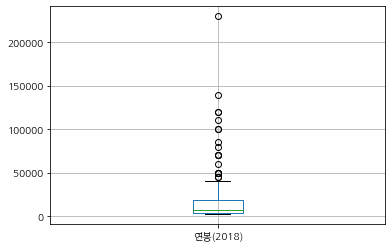

In [11]:
# 연봉의 상자 그림을 출력
picher.boxplot(column=['연봉(2018)'])

- '선수명', '팀명'과 같이 그래프로 표현할 수 없는 피처들을 제외
- 모든 수치형 피처의 분포를 시각화

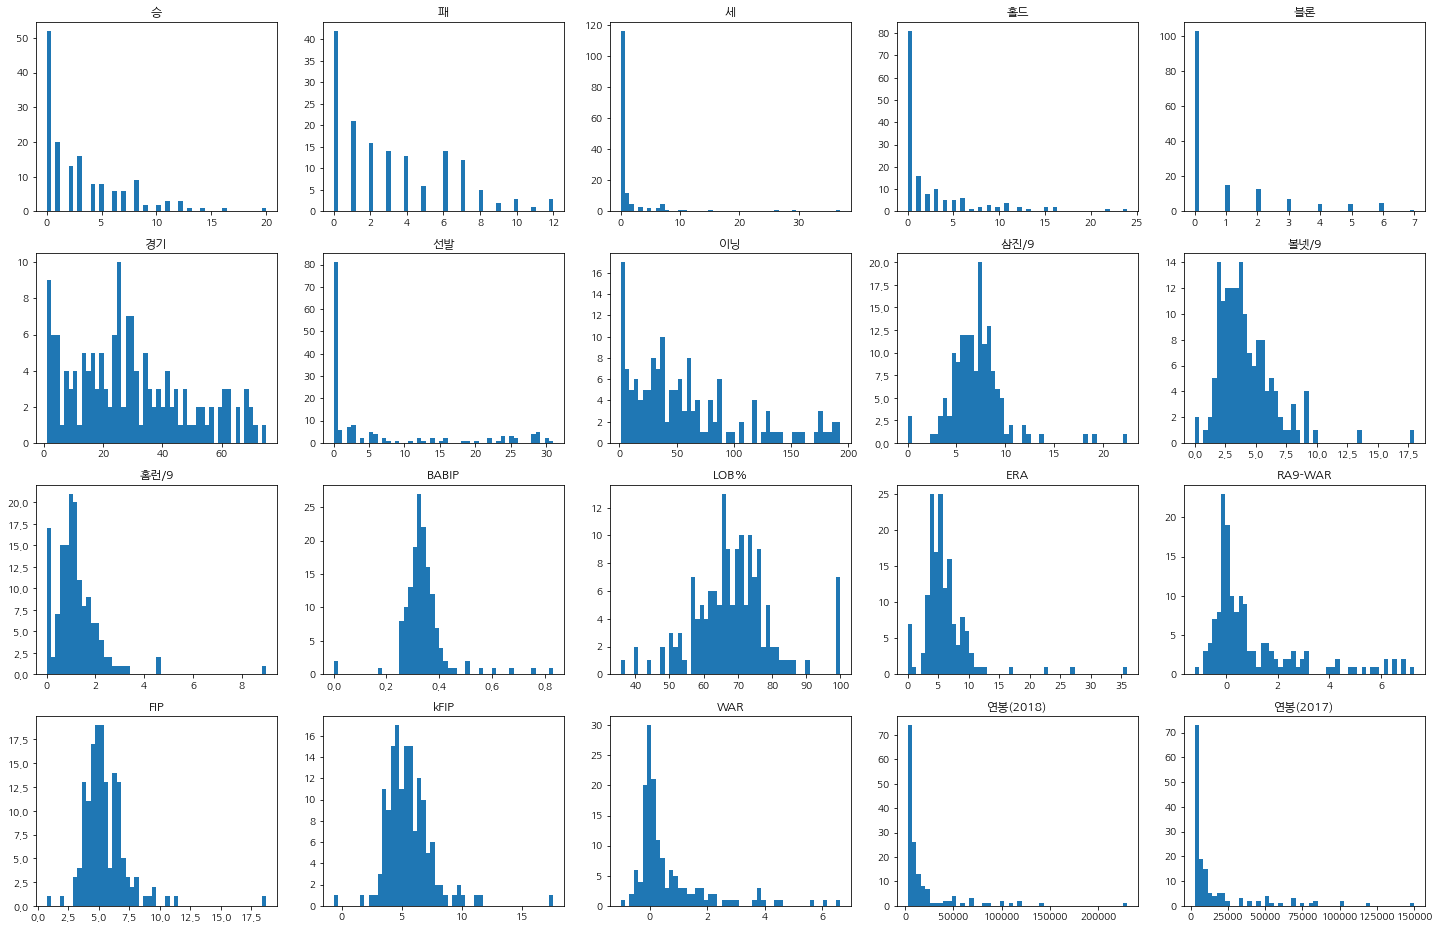

In [13]:
# 회귀 분석에 사용할 피처 살펴보기
picher_features_df = picher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)']]

# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.tight_layout() # 겹치지 않게 여백 주기
    plt.show()

plot_hist_each_column(picher_features_df)

- 각 피처 간의 단위가 다름 => 피처의 정규화 혹은 스케일링이 되어있지 않은 데이터


피처의 정규화(피처 스케일링)
- 피처들의 단위를 0~1 사이, 혹은 상대적 값을 표현할 수 있는 수치로 맞춰주는 것


## step 2 예측 : 투수의 연봉 예측하기
z-값 = ((X) - (X의 평균)) / X의 표준편차

In [14]:
# 피처들의 단위 맞춰주기 : 피처 스케일링
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']
picher_df = standard_scaling(picher, scale_columns)

picher_df = picher_df.rename(columns={'연봉(2018)': 'y'})
picher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


범주형 피처에는 **원-핫 인코딩** 방법 적용
판다스의 get_dummies() 함수로 원-핫 인코딩 적용 가능

In [15]:
# 팀명 피처를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [16]:
team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


모델의 학습 데이터셋(학습 전용 데이터셋)과 모델의 테스트 데이터셋(테스트 전용 데이터셋)으로 데이터를 분리
- sklearn 모듈의 train_test_split()함수로 수행 가능
- (X_train, y_train):(X_test, y_test) = 8:2 비율로 총 4개의 데이터 생성
- X_train, y_train은 학습 데이터셋, X_test, y_test는 테스트 데이터셋

In [20]:
# ! pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 7.2/7.2 MB 9.4 MB/s eta 0:00:00
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=1203b86e92f2f0c3f4aebd46b24c3d302082d466773524adf17fbc352d8dcbf2
  Stored in directory: c:\users\sjy98\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [21]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])] # '선수명', 'y' 제외하고 선택
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19) # random_state: 분할시 셔플이 이루어지는데 이를 위한 시드 값

In [22]:
# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력합니다.
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


## step 3 평가 : 예측 모델 평가하기
회귀 분석은 statsmodel 라이브러리의 OLS 클래스로도 실행 가능  
OLS 클래스의 summary() 함수를 사용하면 다음의 실행 결과처럼 계수에 대한 자세한 분석 내용을 볼 수 있음

In [23]:
! pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 17.7 MB/s eta 0:00:00
     ------------------------------------- 233.7/233.7 KB 14.0 MB/s eta 0:00:00


In [24]:
# 어떤 피처가 가장 영향력이 강한 피처일까
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           7.70e-42
Time:                        20:48:52   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     3.56e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

- 결정 계수(R-squared), 혹은 수정 결정 계수(Adj.R-squared)는 회귀 분석이 얼마나 잘 되었는지 평가하는 지표  
- '회귀 분석으로 추정한 모델이 주어진 데이터를 얼마나 잘 설명하는가?'에 대한 점수  
- 이 점수가 1에 가까울수록 데이터를 잘 설명하는 모델

- F 통계량(F-statistic)은 회귀식의 유의성 검정에 사용되는 값
- F 통계량에 대한 p-value인 Prob(F-statistic) 수치와 함께 봐야 한다
- 일반적으로 p-value가 0.05 이하면 'F 통계량이 유의한 의미를 가진다' 라는 결론을 내려도 무방하며 이는 회귀 분석이 유의미한 결과를 가진다는 것
- P > |t|: 각 피처의 검정 통계량 (t-statistics)이 얼마나 유의미한지에 대한 p-value를 나타내는 것('WAR', '연봉(2017)', '한화' 3개 피처의 p-value가 0.05 미만으로 나타났기 때문에 회귀분석에서 유의미한 피처들이라는 결론 내릴 수 있음)


학습한 coef(계수) 값들을 시각화

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

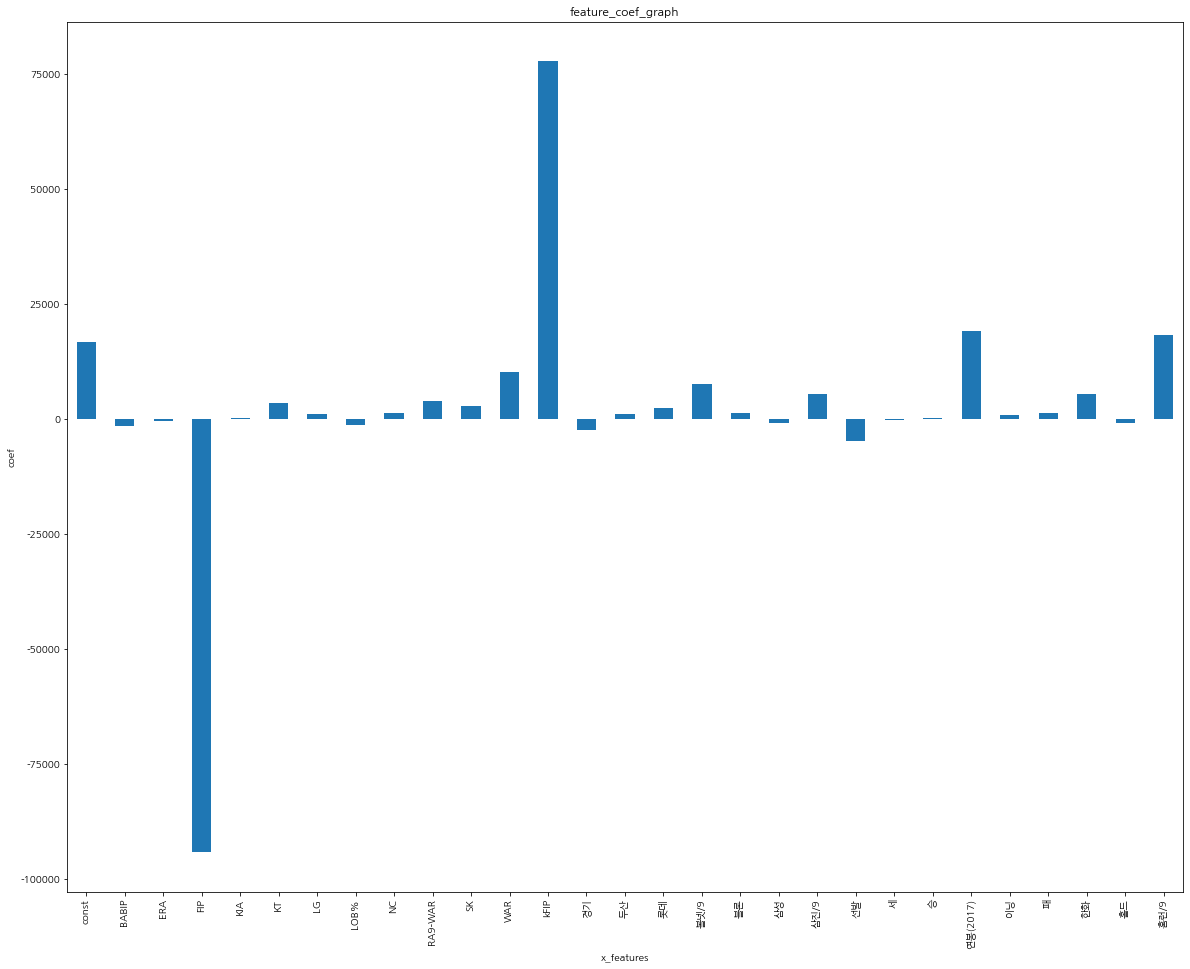

In [27]:
# 어떤 피처가 가장 영향력이 강한 피처일까

# 한글 출력을 위한 사전 설정 단계입니다.
mpl.rc('font', family='NanumGothic')
plt.rcParams['figure.figsize'] = [20, 16]

# 그래프에서 마이너스 부호 나오게
mpl.rcParams['axes.unicode_minus'] = False 

# 회귀 계수를 리스트로 반환합니다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환합니다.
x_labels = model.params.index.tolist()

# 회귀 계수를 출력합니다.
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

수정 결정 계수(R2 score)를 sklean의 LinearRegression 클래스로 출력

In [28]:
# 예측 모델의 평가하기 : R2 score
# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [29]:
# 회귀 분석 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [30]:
# 회귀 분석 모델을 평가합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9276949405576705
0.8860171644977818


- 실행 결과의 각 값은 학습 데이터셋과 테스트 데이터셋에 대한 평가 점수 의미
- 이 두 점수는 최대한 벌어지지 않는 것이 좋음
- 만약 학습 점수가 테스트 점수에 비해 높다면 과적합 발생


RMSE score라는 측정 지표 활용할 수 있음
- 이 점수는 실제값과 예측값의 차이를 절대적인 수치로 나타낸것
- 이 값이 높으면 높을수록 예측이 부정확하다는 것을 의미

In [32]:
# 예측 모델의 평가하기 : RMSE score
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7282.718684746374
14310.696436889131


미니 퀴즈 3-1  
Train score, Test score의 차이점은? 어떤 점수가 더 높아야 할까?
- 훈련 데이터셋은 모델을 학습하는 용도로 사용, 테스트 데이터셋은 결과를 평가하기 위한 용도로만 활용
- Train score, Test score는 이 두 데이터 각각으로만 평가한 점수
- Train score, Test score가 차이가 없는 것이 이상적임




피처들의 상관 관계를 살펴보기 위해 heatmap 방식의 시각화 사용

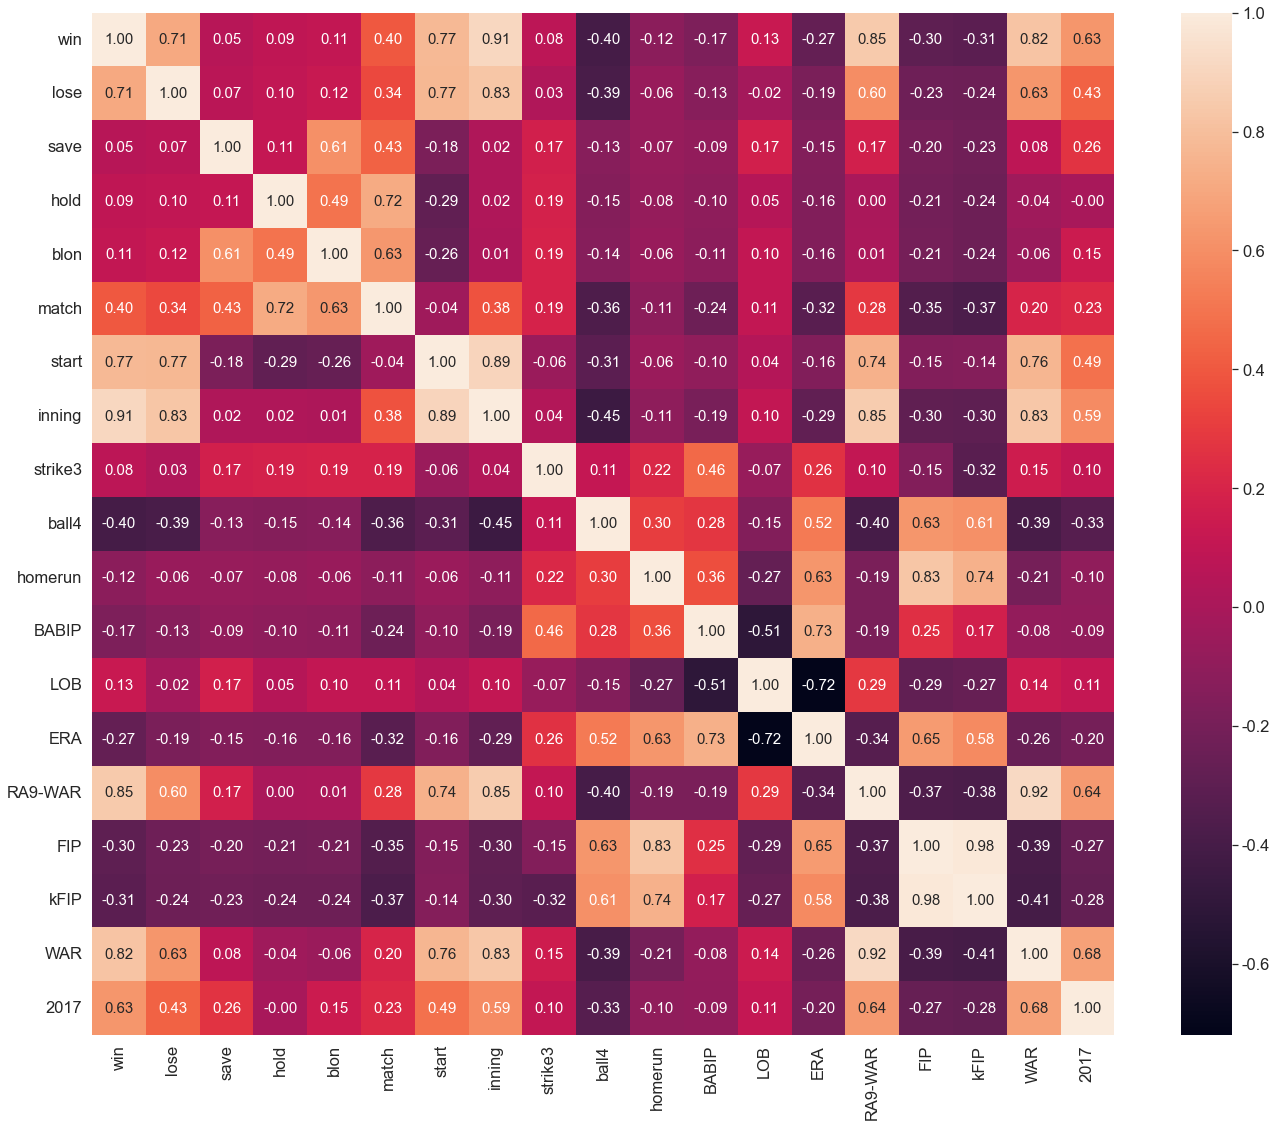

In [33]:
# 피처들의 상관 관계 분석하기

import seaborn as sns

# 피처간의 상관계수 행렬을 계산합니다.
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

- 회귀 분석은 피처 간의 '독립성'을 전제로 하는 분석 방법이기 때문에 올바른 회귀 분석을 하려면 이러한 피처 쌍을 제거해야함
- **다중 공선성**: 변수 간 상관 관계가 높아 분석에 부정적인 영향을 미치는 것을 의미
- 다중 공선성을 살펴봄으로써 여러 피처 간의 연관성을 고려했을 때 어떤 피처를 제거하는 것이 옳은 판단일지 혹은 제거하는 것 자체가 맞는 판단인지에 대한 기준을 제시해줄 수 있음
- 다중 공선성은 분산팽창요인(VIF)이라는 계수로 평가할 수 있음
    - VIF 계수가 10~15 정도를 넘으면 그 피처는 다중 공선성의 문제가 발생했다고 판단

In [34]:
# 회귀 분석 예측 성능을 높이기 위한 방법 : 다중 공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


미니 퀴즈 3-2

In [35]:
# 피처를 재선정합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [36]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [37]:
# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9150591192570362
0.9038759653889866


In [38]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7893.462873347693
13141.866063591076


In [39]:
# 피처마다의 VIF 계수를 출력합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


## step 4 시각화 : 분석 결과 시각화하기
회귀 분석을 통해 얻어낸 예측 연봉과 2018년의 실제 연봉 데이터를 비교하는 시각화 자료 만들기  
predict()함수를 사용하여 2018년의 연봉을 예측하고, 이를 원래 데이터 프레임에 '예측연봉'이라는 새로운 열로 합침  

In [42]:
# 예측연봉과 실제연봉 비교하기
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
picher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)
picher_df

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화,예측연봉(2018)
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,0,0,0,0,1,0,0,0,0,120122.822204
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,0,0,1,0,0,0,0,0,0,88127.019455
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,1,0,0,0,0,0,0,0,0,163930.148696
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,0,0,1,0,0,0,0,0,0,116009.684582
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,0,0,0,0,0,0,1,0,0,102253.697589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,-0.309907,0.588357,-0.306452,-0.585705,0.680497,0.214300,-0.112010,0.104300,-0.968896,...,0,0,0,0,0,0,0,0,1,3080.623786
148,정용운,-0.051084,-0.369825,-0.306452,-0.585705,-0.543592,-0.198678,0.503369,0.042667,-0.777918,...,1,0,0,0,0,0,0,0,0,-395.321720
149,노경은,-0.827554,-0.369825,-0.306452,-0.585705,-0.543592,-1.024633,-0.419699,-0.850019,-0.756699,...,0,0,0,0,0,0,1,0,0,8896.091512
150,김승현,-0.827554,-0.050431,-0.306452,-0.364245,-0.543592,0.627278,-0.624825,-0.273451,0.205264,...,0,0,0,0,0,0,0,1,0,-2185.865106


In [43]:
# 원래의 데이터 프레임을 다시 불러옵니다.
picher = pd.read_csv(picher_file_path)
picher = picher[['선수명', '연봉(2017)']]
picher

,선수명,연봉(2017)
0,켈리,85000
1,소사,50000
2,양현종,150000
3,차우찬,100000
4,레일리,85000
...,...,...
147,장민재,8100
148,정용운,3100
149,노경은,16000
150,김승현,2900


In [44]:
# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = picher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(picher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']
result_df

,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,양현종,230000,163930.148696,150000
1,켈리,140000,120122.822204,85000
2,소사,120000,88127.019455,50000
3,정우람,120000,108489.464585,120000
4,레일리,111000,102253.697589,85000
...,...,...,...,...
147,장지훈,2800,249.850641,2700
148,차재용,2800,900.811527,2800
149,성영훈,2700,5003.619609,2700
150,정동윤,2700,2686.350884,2700


In [45]:
# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


<AxesSubplot:xlabel='선수명'>

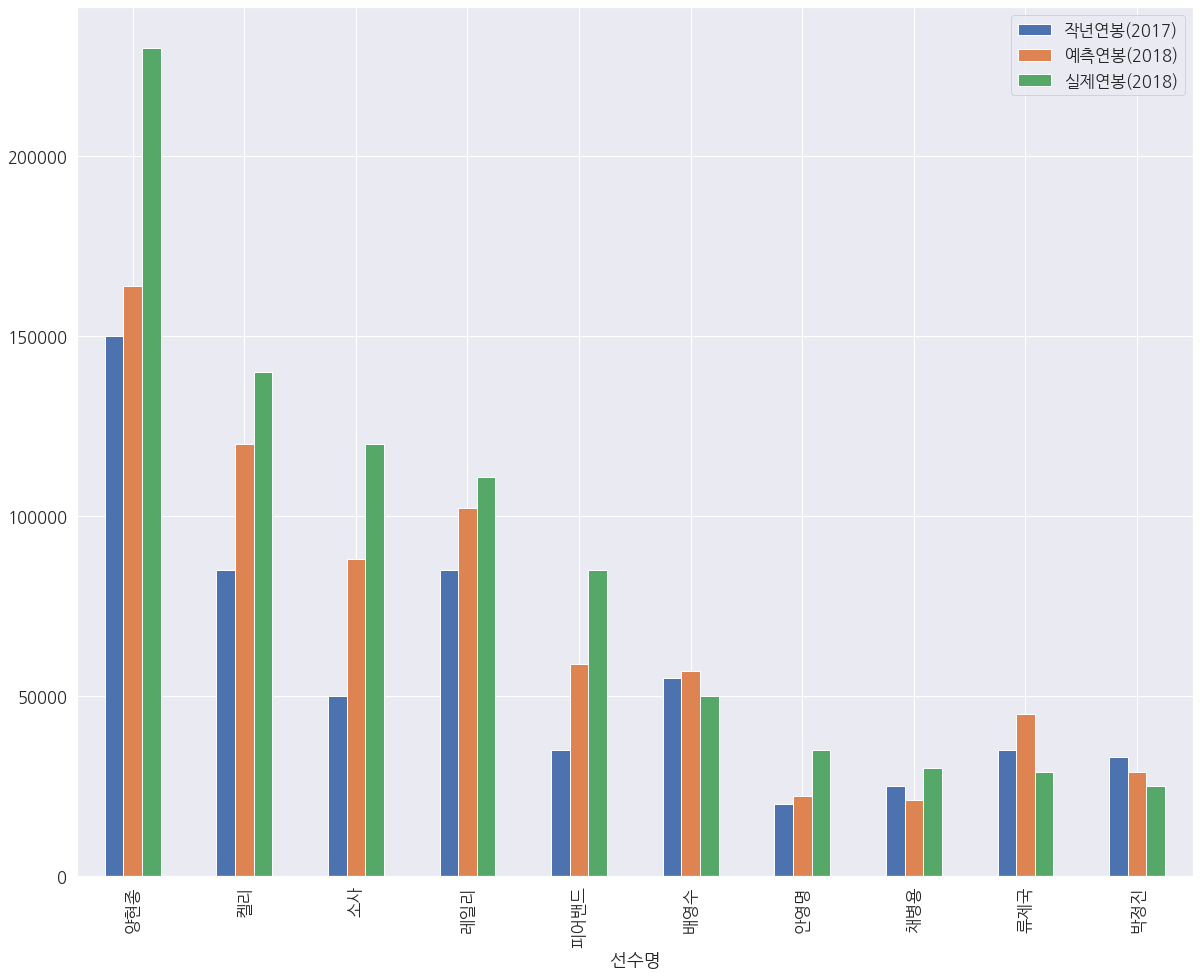

In [47]:
# 선수별 연봉 정보(작년 연봉, 예측 연봉, 실제 연봉)를 bar 그래프로 출력합니다.
mpl.rc('font', family='NanumGothic')
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind="bar")